In [1]:
%matplotlib inline
import netCDF4
from netCDF4 import Dataset
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'couplingSettings.set'
argv2 = r'modelPaths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## create PCR model BMI object

In [5]:
PCR_config_fn = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')
print(PCR_in_dir)
print(PCR_config_fn)
print(PCR_out_dir)

PCR_bmi = PCR_model(PCR_config_fn, PCR_in_dir, PCR_out_dir,
                            start_date, end_date,)


/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/input30min/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe.ini
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR


## create DFM model BMI object

In [6]:
DFM_engine = os.path.join(cwd, options['DFM_engine']['DFM_path'])
DFM_model_dir = os.path.join(cwd, options['hydrodynamic_model']['model_dir'])
DFM_config_fn = os.path.join(DFM_model_dir, options['hydrodynamic_model']['model_file'])
DFM_out_dir = os.path.join(out_dir, 'DFM')
print(DFM_engine)
print(DFM_model_dir)
print(DFM_config_fn)
print(DFM_out_dir)


DFM_bmi = DFM_model(DFM_engine, DFM_config_fn, DFM_model_dir, DFM_out_dir,
                              start_date, end_date)

/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/DFM_Elbe/delta/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/DFM_Elbe/delta/DFM_Elbe_VU.mdu
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/DFM


## intitialize DFM model first to expose 1d coords

In [7]:
# initialize DFM to expose model coordinates via BMI
DFM_bmi.initialize()

## set coupling between PCR and DFM

Couple external 1d coordinates to internal model 2d grid. 

From the green cells with value 1 (green) runoff is couled for the cells with value 2 (yellow) discharge is coupled

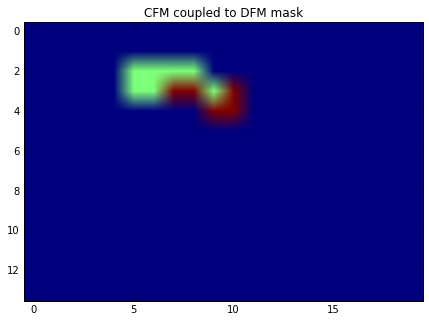

In [8]:
# get coupled dictionaries
PCR_bmi.couple_grid_to_1d(DFM_bmi)

fig = plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
plt.imshow(PCR_bmi.coupled_mask, vmin=0, vmax=2)
b.set_title('CFM coupled to DFM mask')

In [9]:
# initialize PCR to after editing ldd grid
PCR_bmi.initialize()

INFO: configuration.initialize_logging(): Model run started at 2018-03-22 16:31:03.575246
2018-03-22 16:31:03,581 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-03-22 16:31:03.575246
INFO: configuration.initialize_logging(): Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-22T16:31:03.575246.log
2018-03-22 16:31:03,586 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-22T16:31:03.575246.log
INFO: configuration.repair_ini_key_names(): Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-03-22 16:31:03,591 pcrglobwb_bmi_v203.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
INFO: configuration.repair_ini_key_names(): The initial condition "subDischargeIni" is not defined. Either "avgDischargeShortIni" or "avgDischargeLongIni" is used in this run. Note that the "sub

## run coupled PCR - DFM model

In [ ]:
# run coupled model for 2 timesteps
def get_PCR_delta_vol():
    # coupled 2d mask
    mask = (PCR_bmi.coupled_mask > 0).astype(float)
    # Q outflow 2D for coupled cells
    # NOTE: see if we can change this for cell inflow, like with the get_CMF_delta_vol
    q_out = PCR_bmi.get_var('discharge') * mask # [m3/s]
    # PCR runoff inflow 2D for coupled cells
    runoff = PCR_bmi.get_var('runoff') * mask # [m3/s]
    # take discharge in most upstream coupled cells, runoff for other cells
    tot_flux = np.where(PCR_bmi.coupled_mask == 2, q_out, runoff)
    # convert flux to volume per day
    delta_vol = tot_flux * PCR_bmi.options['dt'] # [m3/day]
    return delta_vol 


DFMidx = DFM_bmi.coupled_idx
DFM_area_1d = DFM_bmi.get_var('ba')[DFMidx]
PCRidx = PCR_bmi.coupled_idx
PCRfrac = PCR_bmi.coupled_area_frac
def set_DFM_forcing():
    PCR_delta_vol = get_PCR_delta_vol() # 2d array [m3/day]
    DFM_depth_conservative = PCR_delta_vol[PCRidx] * PCRfrac / DFM_area_1d # 1d array for coupld DFM cells [m/day]
    DFM_bmi.set_var_index('rain', DFMidx, DFM_depth_conservative)

In [ ]:
tStart = datetime.now()
# for i in range(timeSteps):
for i in range(365):
    PCR_bmi.update()
    set_DFM_forcing()
    DFM_bmi.update()  

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-01
2018-03-22 16:31:17,821 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
INFO: pcrglobwb.update(): updating model to time 2000-01-01
2018-03-22 16:31:18,081 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-22 16:31:20,171 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 86400.0, timestep 86400.0
2018-03-22 16:31:20,983 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 86400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-02
2018-03-22 16:31:20,986 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-02
INFO: pcrglobwb.update(): updating model to time 2000-01-02


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 950400.0, timestep 86400.0
2018-03-22 16:31:38,506 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 950400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-12
2018-03-22 16:31:38,512 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-12
INFO: pcrglobwb.update(): updating model to time 2000-01-12
2018-03-22 16:31:38,868 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-12, timestep 12
2018-03-22 16:31:39,964 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-12, timestep 12
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1036800.0, timestep 86400.0
2018-03-22 16:31:40,066 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1036800.0, timestep 

INFO: pcrglobwb.update(): updating model to time 2000-01-22
2018-03-22 16:31:56,534 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-22, timestep 22
2018-03-22 16:31:57,594 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-22, timestep 22
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1900800.0, timestep 86400.0
2018-03-22 16:31:57,718 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1900800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-23
2018-03-22 16:31:57,720 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-23
INFO: pcrglobwb.update(): updating model to time 2000-01-23
2018-03-22 16:31:58,124 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, c

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
2018-03-22 16:32:15,992 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-02
2018-03-22 16:32:15,995 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-02
INFO: pcrglobwb.update(): updating model to time 2000-02-02
2018-03-22 16:32:16,431 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-02, timestep 33
2018-03-22 16:32:17,596 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-02, timestep 33
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2851200.0, timestep 86400.0
2018-03-22 16:32:18,090 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2851200.0, timeste

INFO: pcrglobwb.update(): updating model to time 2000-02-12
2018-03-22 16:32:34,601 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-12, timestep 43
2018-03-22 16:32:35,708 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-12, timestep 43
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3715200.0, timestep 86400.0
2018-03-22 16:32:35,930 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3715200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-13
2018-03-22 16:32:35,936 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-13
INFO: pcrglobwb.update(): updating model to time 2000-02-13
2018-03-22 16:32:36,361 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, c

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4579200.0, timestep 86400.0
2018-03-22 16:32:53,487 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4579200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-23
2018-03-22 16:32:53,491 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-23
INFO: pcrglobwb.update(): updating model to time 2000-02-23
2018-03-22 16:32:53,916 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-23, timestep 54
2018-03-22 16:32:55,063 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-23, timestep 54
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4665600.0, timestep 86400.0
2018-03-22 16:32:55,599 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4665600.0, timeste

INFO: pcrglobwb.update(): updating model to time 2000-03-04
2018-03-22 16:33:11,532 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-04, timestep 64
2018-03-22 16:33:12,671 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-04, timestep 64
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5529600.0, timestep 86400.0
2018-03-22 16:33:13,211 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5529600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-05
2018-03-22 16:33:13,214 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-05
INFO: pcrglobwb.update(): updating model to time 2000-03-05
2018-03-22 16:33:13,653 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, c

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6393600.0, timestep 86400.0
2018-03-22 16:33:31,272 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6393600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-15
2018-03-22 16:33:31,277 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-15
INFO: pcrglobwb.update(): updating model to time 2000-03-15
2018-03-22 16:33:31,669 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-15, timestep 75
2018-03-22 16:33:32,774 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-15, timestep 75
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6480000.0, timestep 86400.0
2018-03-22 16:33:33,244 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6480000.0, timeste

INFO: pcrglobwb.update(): updating model to time 2000-03-25
2018-03-22 16:33:49,440 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-25, timestep 85
2018-03-22 16:33:50,530 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-25, timestep 85
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7344000.0, timestep 86400.0
2018-03-22 16:33:50,823 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7344000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-26
2018-03-22 16:33:50,829 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-26
INFO: pcrglobwb.update(): updating model to time 2000-03-26
2018-03-22 16:33:51,292 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, c

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8208000.0, timestep 86400.0
2018-03-22 16:34:10,011 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8208000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-05
2018-03-22 16:34:10,013 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-05
INFO: pcrglobwb.update(): updating model to time 2000-04-05
2018-03-22 16:34:10,364 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-05, timestep 96
2018-03-22 16:34:11,501 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-05, timestep 96
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8294400.0, timestep 86400.0
2018-03-22 16:34:11,642 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8294400.0, timeste

INFO: pcrglobwb.update(): updating model to time 2000-04-15
2018-03-22 16:34:30,840 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-15, timestep 106
2018-03-22 16:34:31,966 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-15, timestep 106
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9158400.0, timestep 86400.0
2018-03-22 16:34:32,568 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9158400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-16
2018-03-22 16:34:32,571 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-16
INFO: pcrglobwb.update(): updating model to time 2000-04-16
2018-03-22 16:34:32,988 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01,

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10022400.0, timestep 86400.0
2018-03-22 16:34:50,827 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10022400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-26
2018-03-22 16:34:50,831 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-26
INFO: pcrglobwb.update(): updating model to time 2000-04-26
2018-03-22 16:34:51,289 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117
2018-03-22 16:34:52,419 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
2018-03-22 16:34:52,543 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10108800.0, t

INFO: pcrglobwb.update(): updating model to time 2000-05-06
2018-03-22 16:35:10,510 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-06, timestep 127
2018-03-22 16:35:11,656 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-06, timestep 127
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10972800.0, timestep 86400.0
2018-03-22 16:35:12,269 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10972800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-07
2018-03-22 16:35:12,272 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-07
INFO: pcrglobwb.update(): updating model to time 2000-05-07
2018-03-22 16:35:12,667 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-0

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11836800.0, timestep 86400.0
2018-03-22 16:35:31,309 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11836800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-17
2018-03-22 16:35:31,315 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-17
INFO: pcrglobwb.update(): updating model to time 2000-05-17
2018-03-22 16:35:31,776 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-17, timestep 138
2018-03-22 16:35:32,900 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-17, timestep 138
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11923200.0, timestep 86400.0
2018-03-22 16:35:33,147 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11923200.0, t

INFO: pcrglobwb.update(): updating model to time 2000-05-27
2018-03-22 16:35:49,538 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148
2018-03-22 16:35:50,692 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
2018-03-22 16:35:50,831 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-28
2018-03-22 16:35:50,836 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-28
INFO: pcrglobwb.update(): updating model to time 2000-05-28
2018-03-22 16:35:51,145 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-0

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13651200.0, timestep 86400.0
2018-03-22 16:36:11,387 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13651200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-07
2018-03-22 16:36:11,391 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-07
INFO: pcrglobwb.update(): updating model to time 2000-06-07
2018-03-22 16:36:11,784 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-07, timestep 159
2018-03-22 16:36:12,944 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-07, timestep 159
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13737600.0, timestep 86400.0
2018-03-22 16:36:13,232 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13737600.0, t

INFO: pcrglobwb.update(): updating model to time 2000-06-17
2018-03-22 16:36:31,065 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-17, timestep 169
2018-03-22 16:36:32,213 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-17, timestep 169
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14601600.0, timestep 86400.0
2018-03-22 16:36:32,321 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14601600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-18
2018-03-22 16:36:32,326 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-18
INFO: pcrglobwb.update(): updating model to time 2000-06-18
2018-03-22 16:36:32,627 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-0

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
2018-03-22 16:36:51,526 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-28
2018-03-22 16:36:51,531 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-28
INFO: pcrglobwb.update(): updating model to time 2000-06-28
2018-03-22 16:36:51,917 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-28, timestep 180
2018-03-22 16:36:53,126 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-28, timestep 180
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15552000.0, timestep 86400.0
2018-03-22 16:36:53,653 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15552000.0, t

INFO: pcrglobwb.update(): updating model to time 2000-07-08
2018-03-22 16:37:11,188 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-08, timestep 190
2018-03-22 16:37:12,334 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-08, timestep 190
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16416000.0, timestep 86400.0
2018-03-22 16:37:12,577 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16416000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-09
2018-03-22 16:37:12,581 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-09
INFO: pcrglobwb.update(): updating model to time 2000-07-09
2018-03-22 16:37:13,001 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-0

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17280000.0, timestep 86400.0
2018-03-22 16:37:31,358 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17280000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-19
2018-03-22 16:37:31,362 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-19
INFO: pcrglobwb.update(): updating model to time 2000-07-19
2018-03-22 16:37:31,819 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-19, timestep 201
2018-03-22 16:37:32,987 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-19, timestep 201
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17366400.0, timestep 86400.0
2018-03-22 16:37:33,594 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17366400.0, t

INFO: pcrglobwb.update(): updating model to time 2000-07-29
2018-03-22 16:37:51,282 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-29, timestep 211
2018-03-22 16:37:52,422 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-29, timestep 211
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18230400.0, timestep 86400.0
2018-03-22 16:37:52,657 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18230400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-30
2018-03-22 16:37:52,664 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-30
INFO: pcrglobwb.update(): updating model to time 2000-07-30
2018-03-22 16:37:53,078 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-0

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19094400.0, timestep 86400.0
2018-03-22 16:38:10,924 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19094400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-09
2018-03-22 16:38:10,927 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-09
INFO: pcrglobwb.update(): updating model to time 2000-08-09
2018-03-22 16:38:11,272 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-09, timestep 222
2018-03-22 16:38:12,413 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-09, timestep 222
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19180800.0, timestep 86400.0
2018-03-22 16:38:12,534 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19180800.0, t

INFO: pcrglobwb.update(): updating model to time 2000-08-19
2018-03-22 16:38:28,400 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-19, timestep 232
2018-03-22 16:38:29,572 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-19, timestep 232
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20044800.0, timestep 86400.0
2018-03-22 16:38:29,912 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20044800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-20
2018-03-22 16:38:29,913 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-20
INFO: pcrglobwb.update(): updating model to time 2000-08-20
2018-03-22 16:38:30,280 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-0

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20908800.0, timestep 86400.0
2018-03-22 16:38:47,803 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20908800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-30
2018-03-22 16:38:47,806 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-30
INFO: pcrglobwb.update(): updating model to time 2000-08-30
2018-03-22 16:38:48,227 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-30, timestep 243
2018-03-22 16:38:49,383 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-30, timestep 243
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20995200.0, timestep 86400.0
2018-03-22 16:38:49,551 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20995200.0, t

INFO: pcrglobwb.update(): updating model to time 2000-09-09
2018-03-22 16:39:06,339 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-09, timestep 253
2018-03-22 16:39:07,450 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-09, timestep 253
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21859200.0, timestep 86400.0
2018-03-22 16:39:07,617 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21859200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-10
2018-03-22 16:39:07,623 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-10
INFO: pcrglobwb.update(): updating model to time 2000-09-10
2018-03-22 16:39:08,095 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-0

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22723200.0, timestep 86400.0
2018-03-22 16:39:25,874 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22723200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-20
2018-03-22 16:39:25,877 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-20
INFO: pcrglobwb.update(): updating model to time 2000-09-20
2018-03-22 16:39:26,320 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-20, timestep 264
2018-03-22 16:39:27,504 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-20, timestep 264
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
2018-03-22 16:39:27,952 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22809600.0, t

INFO: pcrglobwb.update(): updating model to time 2000-09-30
2018-03-22 16:39:44,201 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-30, timestep 274
2018-03-22 16:39:45,338 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-30, timestep 274
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23673600.0, timestep 86400.0
2018-03-22 16:39:45,558 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23673600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-01
2018-03-22 16:39:45,563 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-01
INFO: pcrglobwb.update(): updating model to time 2000-10-01
2018-03-22 16:39:45,975 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-0

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24537600.0, timestep 86400.0
2018-03-22 16:40:03,519 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24537600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-11
2018-03-22 16:40:03,524 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-11
INFO: pcrglobwb.update(): updating model to time 2000-10-11
2018-03-22 16:40:03,950 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-11, timestep 285
2018-03-22 16:40:05,088 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-11, timestep 285
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24624000.0, timestep 86400.0
2018-03-22 16:40:05,494 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24624000.0, t

INFO: pcrglobwb.update(): updating model to time 2000-10-21
2018-03-22 16:40:22,042 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-21, timestep 295
2018-03-22 16:40:23,163 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-21, timestep 295
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
2018-03-22 16:40:23,299 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-22
2018-03-22 16:40:23,305 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-22
INFO: pcrglobwb.update(): updating model to time 2000-10-22
2018-03-22 16:40:23,634 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-0

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26352000.0, timestep 86400.0
2018-03-22 16:40:40,320 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26352000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-01
2018-03-22 16:40:40,323 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-01
INFO: pcrglobwb.update(): updating model to time 2000-11-01
2018-03-22 16:40:40,727 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-01, timestep 306
2018-03-22 16:40:42,212 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-01, timestep 306
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26438400.0, timestep 86400.0
2018-03-22 16:40:42,388 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26438400.0, t

INFO: pcrglobwb.update(): updating model to time 2000-11-11
2018-03-22 16:40:58,334 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-11, timestep 316
2018-03-22 16:40:59,447 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-11, timestep 316
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27302400.0, timestep 86400.0
2018-03-22 16:40:59,567 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27302400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-12
2018-03-22 16:40:59,573 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-12
INFO: pcrglobwb.update(): updating model to time 2000-11-12
2018-03-22 16:40:59,909 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-0

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
2018-03-22 16:41:17,624 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-22
2018-03-22 16:41:17,630 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-22
INFO: pcrglobwb.update(): updating model to time 2000-11-22
2018-03-22 16:41:18,055 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-22, timestep 327
2018-03-22 16:41:19,211 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-22, timestep 327
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28252800.0, timestep 86400.0
2018-03-22 16:41:19,381 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28252800.0, t

INFO: pcrglobwb.update(): updating model to time 2000-12-02
2018-03-22 16:41:36,527 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-02, timestep 337
2018-03-22 16:41:37,730 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-02, timestep 337
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29116800.0, timestep 86400.0
2018-03-22 16:41:38,120 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29116800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-03
2018-03-22 16:41:38,123 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-03
INFO: pcrglobwb.update(): updating model to time 2000-12-03
2018-03-22 16:41:38,529 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-0

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29980800.0, timestep 86400.0
2018-03-22 16:41:56,274 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29980800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-13
2018-03-22 16:41:56,280 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-13
INFO: pcrglobwb.update(): updating model to time 2000-12-13
2018-03-22 16:41:56,735 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-13, timestep 348
2018-03-22 16:41:57,865 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-13, timestep 348
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30067200.0, timestep 86400.0
2018-03-22 16:41:58,034 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30067200.0, t

INFO: pcrglobwb.update(): updating model to time 2000-12-23
2018-03-22 16:42:15,211 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-23, timestep 358


In [ ]:
tEnd = datetime.now()

In [ ]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd

In [ ]:
DFM_bmi.finalize()
PCR_bmi.finalize()

In [ ]:
#- load DFM output file (from this model run)
fo = os.path.join(DFM_out_dir, 'DFM_OUTPUT_DFM_Elbe_VU/', 'DFM_Elbe_VU_his.nc')
no = Dataset(fo, 'r')
#- extract simulated discharge from nc-file (for this run)
qsim = no.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC = np.absolute(qsim[:,2])
qsim_ND = np.absolute(qsim[:,0])
qsim_downBC = np.absolute(qsim[:,1])

#- laod DFM output file (from DFM stand alone)
fo_stA = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_standAlone_his.nc')
no_stA = Dataset(fo_stA, 'r')
#- extract simulated discharge from nc-file for DFM standalone
qsim_stA = no_stA.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_stA = np.absolute(qsim_stA[:,2])
qsim_ND_stA = np.absolute(qsim_stA[:,0])
qsim_downBC_stA = np.absolute(qsim_stA[:,1])

#- load BfG file
vo = os.path.join(cwd, 'test_Elbe/', 'Elbe-W+Q.csv')
#- extract BfG data for NeuDarchau
vd = np.loadtxt(vo, unpack=True, converters = {0: mdates.strpdate2num('%d-%m-%y')}, delimiter=';', skiprows=4)
qobs_ND = vd[1]

#- limit to list with least entries
minLength = min(len(qobs_ND), len(qsim_ND), len(qsim_ND_stA))
if len(qobs_ND) > len(qsim_ND):
    qsim_ND = qsim_ND[:minLength]
    qobs_ND = qobs_ND[:minLength]
    qsim_ND_stA = qsim_ND_stA[:minLength]
    
#- computed KGE at NeuDarchau
KGE_ND = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND)
KGE_ND = np.round(KGE_ND,2)
KGE_ND_stA = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_stA)
KGE_ND_stA = np.round(KGE_ND_stA,2)

#- plot
plt.figure(figsize=(16,8))
plt.plot(qsim_ND, 'b', label = 'PCR->DFM')
plt.plot(qsim_ND_stA, 'g', label = 'DFM')
plt.plot(qobs_ND, 'm', label = 'OBS')
plt.text(len(qsim_ND)+1,4900, 'KGEs') 
plt.text(len(qsim_ND)+1,4600, 'DFM : '+str(KGE_ND_stA))
plt.text(len(qsim_ND)+1,4300, 'PCR->DFM : '+str(KGE_ND))
plt.legend(ncol=2, loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))
plt.savefig(os.path.join(cwd, 'compareAndvalidate_Qsim_PCR2DFM.png'), dpi=300)